__DSC 478:__

__Jonathan Lynch:__

# Assignment 3 - Part 2:

## Document Clustering:

__Import libraries:__

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import completeness_score, homogeneity_score
import math
from wordcloud import WordCloud

## A: Create distance function that uses Cosine similarity:

In [2]:
def cosSim(vec_A, vec_B):
    norm_A = linalg.norm(vec_A)
    norm_B = linalg.norm(vec_B)
    cosine = dot(vec_A, vec_B) / (norm_A * norm_B)
    dist = 1 - cosine
    return dist

## B: Load the data, and split DxT matrix into training/test sets: 

__Load data:__

In [3]:
%cd "/Users/jonathanlynch/Desktop/DSC 478/newsgroups5"

matrix = np.genfromtxt("matrix.txt", delimiter=',',dtype=int).T  # transpose to have DxT matrix

classes = np.genfromtxt("classes.txt", delimiter=' ', dtype=int, skip_header=1, usecols=(1))

terms = pd.read_table('terms.txt', sep='\n', header=None)

/Users/jonathanlynch/Desktop/DSC 478/newsgroups5


In [4]:
matrix.shape

(2500, 9328)

In [5]:
classes.shape

(2500,)

In [6]:
terms.shape

(9328, 1)

__Split data matrix into training and test sets:__

In [7]:
train, test, classes_train, classes_test = train_test_split(matrix, classes, test_size = 0.2) # split into training/test sets

## C: Perform Kmeans clustering on the training data: write function to display the top N terms in each cluster along with the cluster DF values for each term & cluster size. Sort the terms for each cluster in decreasing order of the DF percentage:

__Functions to create k random centroids & assign data points to clusters (based on closest centroid):__

In [8]:
# Implementation from Chapter 10 of Machine Learning in Action:

def randCent(dataSet, k):
    'returns random centroids'
    n = shape(dataSet)[1]
    centroids = zeros((k,n), dtype=float)
    for j in range(n):
        minJ = min(dataSet[:,j])
        rangeJ = float(max(dataSet[:,j]) - minJ)
        centroids[:,j] = minJ + rangeJ * random.rand(k) 
    return centroids

def kMeans(dataSet, k, distMeas=cosSim, createCent=randCent):
    'returns centroids and cluster assignments for points'
    m = shape(dataSet)[0]
    clusterAssment = zeros((m,2)) # create mat to assign data points to a centroid, also holds SE of each point
    centroids = createCent(dataSet, k)
    clusterChanged = True
    while clusterChanged:
        clusterChanged = False
        for i in range(m):  # for each data point assign it to the closest centroid
            minDist = inf; minIndex = -1
            for j in range(k):
                distJI = distMeas(centroids[j,:],dataSet[i,:])
                if distJI < minDist:
                    minDist = distJI; minIndex = j
            if clusterAssment[i,0] != minIndex: clusterChanged = True
            clusterAssment[i,:] = minIndex,minDist**2
        # print centroids
        for cent in range(k):  # recalculate centroids
            ptsInClust = dataSet[nonzero(clusterAssment[:,0]==cent)[0]] #get all the point in this cluster
            if(len(ptsInClust)!=0):
                centroids[cent,:] = mean(ptsInClust, axis=0) #assign centroid to mean
    return centroids, clusterAssment

In [9]:
centroids, clusters = kMeans(train, 5, cosSim, randCent)

__Function to display top N terms in each cluster, DF values for each term (sorted by DF perentage), & cluster size:__

In [10]:
def topTerms(N, clusters, train, terms):
    num = int(max(clusters[:,0])+1)
    clusters = pd.DataFrame(clusters)  # convert to df
    for i in range(num):
        cluster = clusters[clusters[0] == i]
        cluster_idx = cluster.index
        train = pd.DataFrame(train)
        cluster_DF = train[train.index.isin(cluster_idx)]
        cluster_DF2 = (cluster_DF != 0).sum()
        cluster_DF2 = pd.DataFrame(cluster_DF2)
        merged = pd.merge(terms, cluster_DF2, left_index=True, right_index=True)
        merged.columns = ['words', 'DF']
        merged.sort_values(by='DF', axis=0, ascending=False, inplace=True)
        top_n = merged.head(N)
        
        print('CLUSTER ' + str(i) + ' results:')
        print('Number of documents in cluster: ' + str(len(cluster)))
        print("\tword\t\tDF\tPercentofDocs")
        
        for top in top_n.itertuples():
            if top.DF > 0:
                PercentofDocs = top.DF/len(cluster)
            else:
                PercentofDocs = 0
            print("%10s\t\t%.0f\t%.6f" %(top.words, top.DF, PercentofDocs))       

In [11]:
topTerms(10, clusters, train, terms)

CLUSTER 0 results:
Number of documents in cluster: 379
	word		DF	PercentofDocs
   subject		379	1.000000
     write		239	0.630607
       god		233	0.614776
        on		226	0.596306
 christian		194	0.511873
     peopl		186	0.490765
    articl		183	0.482850
     think		169	0.445910
    believ		158	0.416887
      know		157	0.414248
CLUSTER 1 results:
Number of documents in cluster: 849
	word		DF	PercentofDocs
   subject		849	1.000000
     write		513	0.604240
    articl		401	0.472320
        on		371	0.436985
       get		322	0.379270
      just		280	0.329800
        go		275	0.323910
     think		248	0.292108
      know		245	0.288575
      good		234	0.275618
CLUSTER 2 results:
Number of documents in cluster: 6
	word		DF	PercentofDocs
   subject		6	1.000000
        al		6	1.000000
        uo		5	0.833333
        mx		5	0.833333
        mw		5	0.833333
        cs		5	0.833333
        yt		5	0.833333
        ng		5	0.833333
        kh		5	0.833333
        cx		5	0.833333
CLUSTER 3 results:
Number of docume

__EXTRA CREDIT:__

__Write script to create strings with words/word frequencies corresponding to each assigned cluster:__

In [12]:
clustersII = pd.DataFrame(clusters)

str0 = ''
str1 = ''
str2 = ''
str3 = ''
str4 = ''
for i in range(5):
    cluster = clustersII[clustersII[0] == i]
    cluster_idx = cluster.index
    train = pd.DataFrame(train)
    cluster_DF = train[train.index.isin(cluster_idx)]
    cluster_summed = cluster_DF.sum()
    cluster_summed = pd.DataFrame(cluster_summed)
    merged = pd.merge(terms, cluster_summed, left_index=True, right_index=True)
    merged.columns = ['words', 'WF']
    for row in merged.itertuples():
        num = row.WF
        if num > 0:
            for n in range(num):
                if i == 0:
                    str0 += row.words + ' '
                elif i == 1:
                    str1 += row.words + ' '
                elif i == 2:
                    str2 += row.words + ' '
                elif i == 3:
                    str3 += row.words + ' '
                elif i == 4:
                    str4 += row.words + ' '

__Create word cloud for cluster 0:__

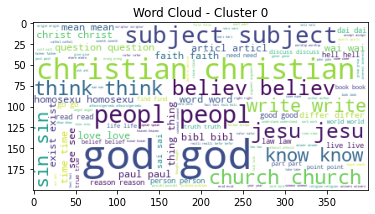

In [13]:
if len(str0) >= 2:
    clust0_wordcloud = WordCloud(background_color='white').generate(str0)
    plt.imshow(clust0_wordcloud)
    plt.title('Word Cloud - Cluster 0')
    plt.show()

__Create word cloud for cluster 1:__

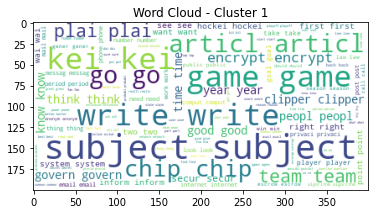

In [14]:
if len(str1) >= 2:
    clust1_wordcloud = WordCloud(background_color='white').generate(str1)
    plt.imshow(clust1_wordcloud)
    plt.title('Word Cloud - Cluster 1')
    plt.show()

__Create word cloud for cluster 2:__

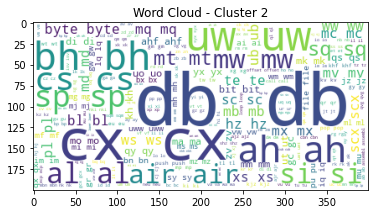

In [15]:
if len(str2) >= 2:
    clust2_wordcloud = WordCloud(background_color='white').generate(str2)
    plt.imshow(clust2_wordcloud)
    plt.title('Word Cloud - Cluster 2')
    plt.show()

__Create word cloud for cluster 3:__

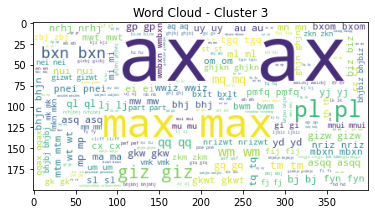

In [16]:
if len(str3) >= 2:
    clust3_wordcloud = WordCloud(background_color='white').generate(str3)
    plt.imshow(clust3_wordcloud)
    plt.title('Word Cloud - Cluster 3')
    plt.show()

__Create word cloud for cluster 4:__

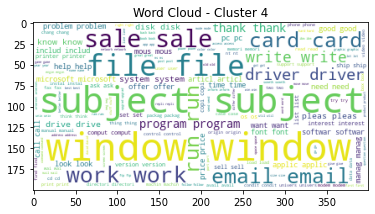

In [17]:
if len(str4) >= 2:
    clust4_wordcloud = WordCloud(background_color='white').generate(str4)
    plt.imshow(clust4_wordcloud)
    plt.title('Word Cloud - Cluster 4')
    plt.show()

## D: Using the cluster assignments from Kmeans clustering, compare your 5 clusters to the 5 pre-assigned classes by computing the Completeness and Homogeneity values:

In [18]:
completeness_values = completeness_score(classes_train, ravel(clusters.T[0]))
homogeneity_values = homogeneity_score(classes_train, ravel(clusters.T[0]))

print('Clusters Completeness: '+  str(completeness_values))
print('Clusters Homogeneity: '+ str(homogeneity_values))

Clusters Completeness: 0.6869486650682148
Clusters Homogeneity: 0.46172290964546825


## E: Categorize each of the documents in the set aside test data to the appropriate cluster based on Cosine Similarity measure between each test document and cluster centroids:

In [19]:
res = []

for doc in test:
    dic = {}
    sim = []
    cluster = 0
    for centroid in centroids:
        doc_sim = 1 - cosSim(doc, centroid) # subtract from 1 to get similarity
        sim.append(doc_sim) 
        dic['document cosine similarity to cluster: '+str(cluster)] = doc_sim
        cluster += 1
    dic['cluster prediction'] = sim.index(max(sim))
    res.append(dic)

cluster_predictions = pd.DataFrame(res)

In [20]:
pd.set_option('display.max_rows', None)   # display all documents' predicted clusters & Cosine Sim measures
cluster_predictions

,document cosine similarity to cluster: 0,document cosine similarity to cluster: 1,document cosine similarity to cluster: 2,document cosine similarity to cluster: 3,document cosine similarity to cluster: 4,cluster prediction
0,0.092152,0.137746,0.001559,0.000014,0.090119,1
1,0.113307,0.169645,0.005113,0.000015,0.112892,1
2,0.111724,0.198097,0.003212,0.000010,0.101531,1
3,0.293376,0.186567,0.007300,0.000006,0.147344,0
4,0.170359,0.240827,0.011316,0.000049,0.157474,1
5,0.067889,0.137590,0.008614,0.000027,0.094679,1
6,0.059972,0.173727,0.010168,0.000010,0.071249,1
7,0.115251,0.246895,0.008621,0.000016,0.136796,1
8,0.121778,0.109775,0.002384,0.000026,0.125470,4
9,0.152665,0.314427,0.013080,0.000019,0.157264,1
